#### Packages

In [1]:
import pathlib
import geopandas
import pandas
import numpy
import numpy as np
import pandas as pd

from scipy.stats import truncnorm
from scipy import stats
import seaborn as sns

import random


import matplotlib.pyplot as plt

In [2]:
save_dir = r"S:\Bathymetry\explain_para"

#### 1. Get data

In [3]:
cache_path = pathlib.Path(r"S:\Example1\DEM_008\dem_bathy_036")
flow_path = pathlib.Path(r"S:\Example1\DEM_008")

In [4]:
river_characteristics = geopandas.read_file(cache_path / "river_characteristics.geojson")
river_bathymetry = geopandas.read_file(cache_path / "river_bathymetry.geojson")
channel = geopandas.read_file(cache_path / "rec_channel_19000000.geojson")
flow_and_friction = pandas.read_csv(flow_path / "flow_and_friction.csv.gz")

In [5]:
flow_name = "flow"
friction_name = "mannings_n"

slope_name = "slope_mean_2.0km"
min_z_name = "min_z_centre_unimodal"
width_name = "widths_mean_0.25km"
flat_width_name = "flat_widths_mean_0.25km"
threshold_name = "thresholds_mean_0.25km"

In [6]:
# Match each channel midpoint to a nzsegment ID - based on what channel reach is closest
river_characteristics["nzsegment"] = (
    numpy.ones(len(river_characteristics["widths"]), dtype=float) * numpy.nan
)
for i, row in river_characteristics.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        # Calculate the distance between the point from points of river_characteristics to channel
        distances = channel.distance(river_characteristics.loc[i].geometry)
        # Choose the closest distances and then choose the minimum nzsegment
        river_characteristics.loc[i, ("nzsegment")] = channel[
            distances == distances.min()
        ]["nzsegment"].min()
        
# Fill in any missing values
river_characteristics["nzsegment"] = (
    river_characteristics["nzsegment"].fillna(method="ffill").fillna(method="bfill")
)
river_characteristics["nzsegment"] = river_characteristics["nzsegment"].astype("int")

# Add the friction and flow values to the widths and slopes
river_characteristics[friction_name] = numpy.zeros(len(river_characteristics["nzsegment"]), dtype=int)
river_characteristics[flow_name] = numpy.zeros(len(river_characteristics["nzsegment"]), dtype=int)

for nzsegment in river_characteristics["nzsegment"].unique():
    river_characteristics.loc[
        river_characteristics["nzsegment"] == nzsegment, (friction_name)
    ] = flow_and_friction[flow_and_friction["nzsegment"] == nzsegment]["n"].unique()[0]
    river_characteristics.loc[river_characteristics["nzsegment"] == nzsegment, (flow_name)] = flow_and_friction[
        flow_and_friction["nzsegment"] == nzsegment
    ][flow_name].unique()[0]

In [7]:
# # Ref: https://stackoverflow.com/questions/24511200/index-of-non-nan-values-in-pandas
# Get indices of nan and notnan rows
index_nan = river_characteristics[river_characteristics.geometry.isna()].index.tolist()
index_notnan = river_characteristics[river_characteristics.geometry.notna()].index.tolist()

# Change river characteristics and river bathymetry
river_characteristics = river_characteristics.drop(index_nan).reset_index(drop=True)
river_bathymetry = river_bathymetry.drop(index_nan).reset_index(drop=True)

#### 2. Function

In [8]:
def calculate_depth(alpha, beta, K_0, slope, width, flow):
    full_bank_depth = ( flow / (K_0 * width * (slope ** beta) ) ) ** (1 / (1 + alpha))
    return full_bank_depth

In [9]:
def calculate_neal_et_al(width, slope, flow, n):
    alpha = 2/3
    beta = 0.5
    K_0 = 1/n
    return calculate_depth(alpha, beta, K_0, slope, width, flow)

In [10]:
def calculate_rupp_et_al(width, slope, flow):
    alpha = 0.745
    beta = 0.305
    K_0 = 6.16
    return calculate_depth(alpha, beta, K_0, slope, width, flow)

#### 3. Main plot

In [11]:
data = {
    'x': river_characteristics.geometry.x,
    'y': river_characteristics.geometry.y,
    'slope': river_characteristics[slope_name],
    'flow': river_characteristics[flow_name],
    'width': river_characteristics[width_name],
    'friction': river_characteristics[friction_name]
}
df = pd.DataFrame(data=data)
df.insert(0, 'distance', range(0, 10 * 1543, 10))

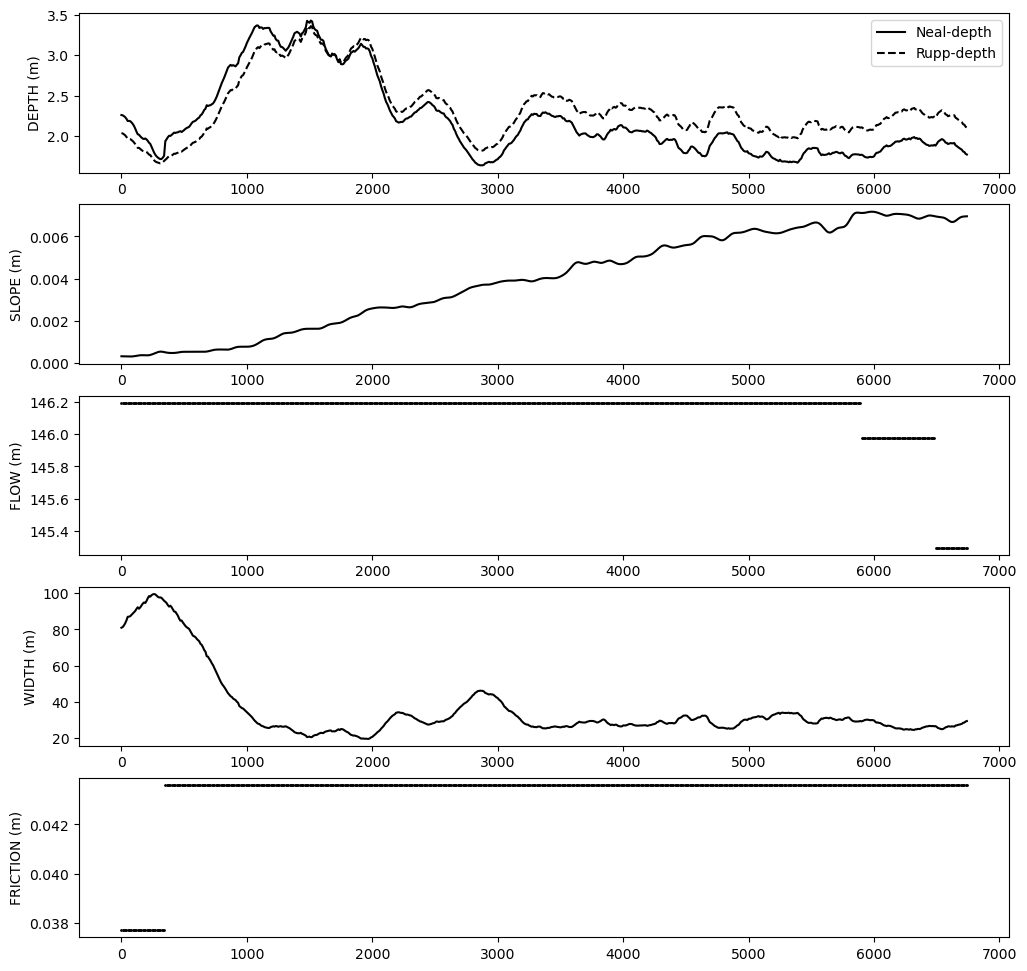

In [12]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12))
ax[0].plot(df[0:675].distance, river_bathymetry[0:675]['flood_depth_Neal_et_al'], color='black', label='Neal-depth')
ax[0].plot(df[0:675].distance, river_bathymetry[0:675]['flood_depth_Rupp_and_Smart'], linestyle='--', color='black', label='Rupp-depth')
ax[0].set_ylabel('DEPTH (m)')

ax[1].plot(df[0:675].distance, df[0:675]['slope'], color='black')
ax[1].set_ylabel('SLOPE (m)')
ax[2].scatter(df[0:675].distance, df[0:675]['flow'], color='black', s=1)
ax[2].set_ylabel('FLOW (m)')
ax[3].plot(df[0:675].distance, df[0:675]['width'], color='black')
ax[3].set_ylabel('WIDTH (m)')
ax[4].scatter(df[0:675].distance, df[0:675]['friction'], color='black', s=1)
ax[4].set_ylabel('FRICTION (m)')

ax[0].legend()

# # Save fig
# fig.savefig(
#     fr"{save_dir}\\full.png",
#     bbox_inches='tight', dpi=330
# )

In [224]:
df[0:115]['slope'].min()

0.0002945770725727002

In [258]:
df[0:105]['flow'].max()

146.193834170136

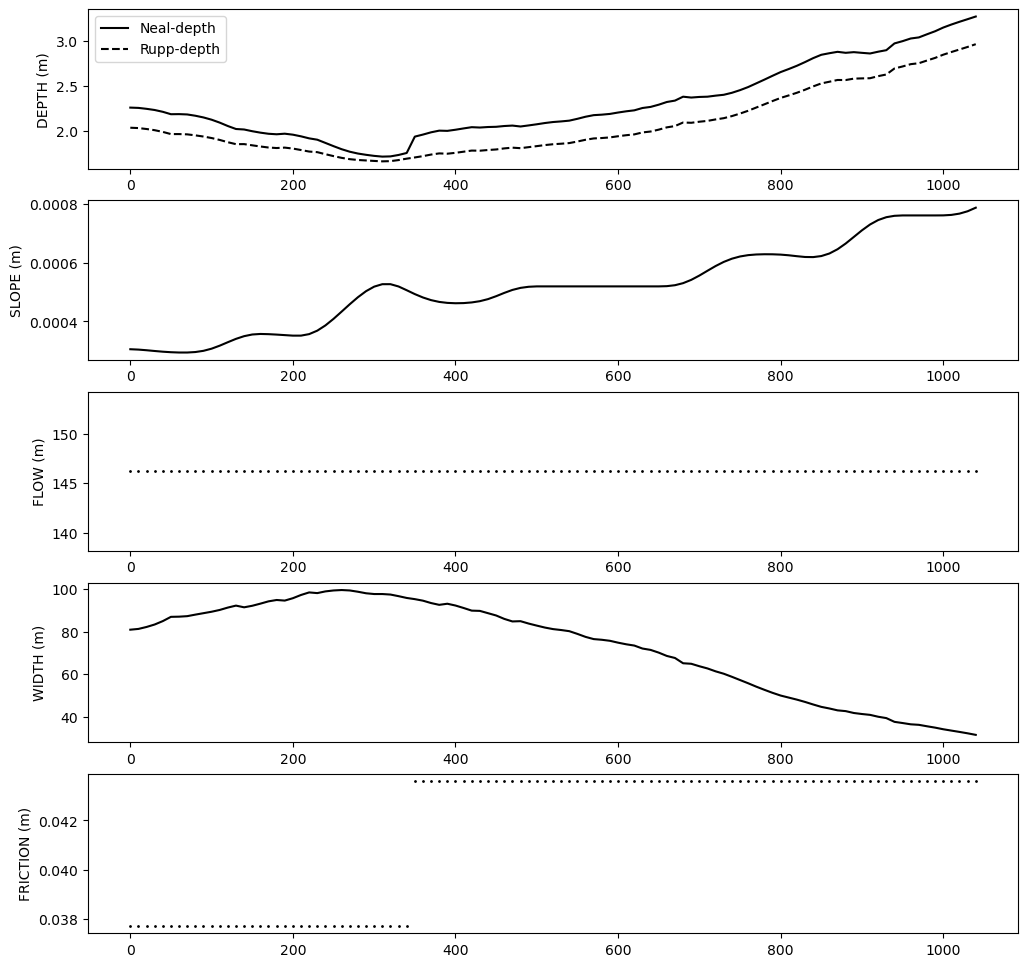

In [220]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12))
ax[0].plot(df[0:105].distance, river_bathymetry[0:105]['flood_depth_Neal_et_al'], color='black', label='Neal-depth')
ax[0].plot(df[0:105].distance, river_bathymetry[0:105]['flood_depth_Rupp_and_Smart'], linestyle='--', color='black', label='Rupp-depth')
ax[0].set_ylabel('DEPTH (m)')

ax[1].plot(df[0:105].distance, df[0:105]['slope'], color='black')
ax[1].set_ylabel('SLOPE (m)')
ax[2].scatter(df[0:105].distance, df[0:105]['flow'], color='black', s=1)
ax[2].set_ylabel('FLOW (m)')
ax[3].plot(df[0:105].distance, df[0:105]['width'], color='black')
ax[3].set_ylabel('WIDTH (m)')
ax[4].scatter(df[0:105].distance, df[0:105]['friction'], color='black', s=1)
ax[4].set_ylabel('FRICTION (m)')

ax[0].legend()

# # Save fig
# fig.savefig(
#     fr"{save_dir}\\full.png",
#     bbox_inches='tight', dpi=330
# )

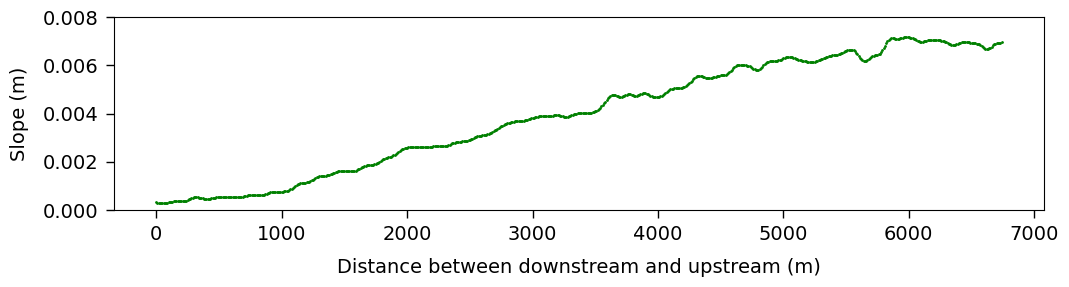

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))

fontsize = 14
labelpad = 10

ax.scatter(df[0:675].distance, df[0:675]['slope'], color='green', s=1)
ax.set_ylabel('Slope (m)', fontsize=fontsize, labelpad=labelpad)
ax.set_xlabel('Distance between downstream and upstream (m)', fontsize=fontsize, labelpad=labelpad)

ax.set_ylim(ymin=0, ymax=0.008)
ax.locator_params(nbins=5, axis='y')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-8, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_slope_waikanae.jpg",
    bbox_inches='tight', dpi=600
)

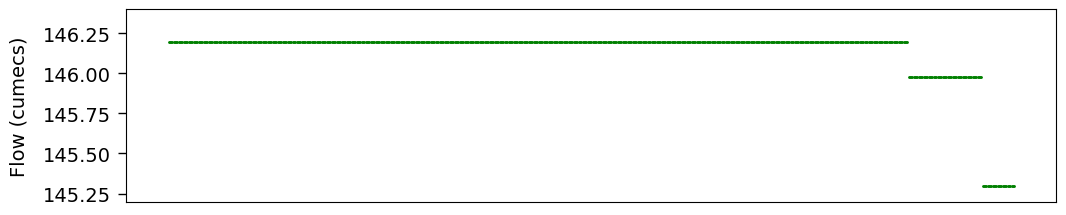

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))

fontsize = 14
labelpad = 10

ax.scatter(df[0:675].distance, df[0:675]['flow'], color='green', s=1)
ax.set_ylabel('Flow (cumecs)', fontsize=fontsize, labelpad=labelpad)

ax.set_ylim(ymin=145.2, ymax=146.4)

ax.set_xticks([])
ax.tick_params(bottom=False)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-8, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_flow_waikanae.jpg",
    bbox_inches='tight', dpi=600
)

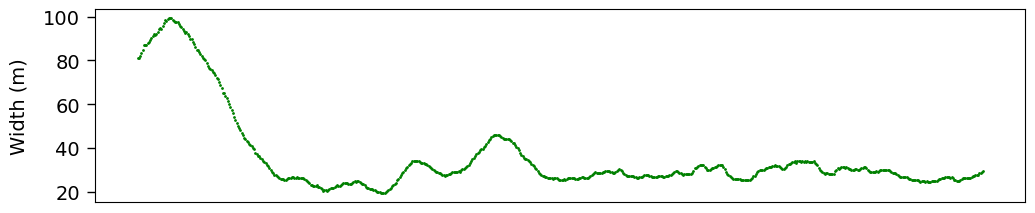

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))

fontsize = 14
labelpad = 10

ax.scatter(df[0:675].distance, df[0:675]['width'], color='green', s=1)
ax.set_ylabel('Width (m)', fontsize=fontsize, labelpad=labelpad)

ax.set_xticks([])
ax.tick_params(bottom=False)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-8, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_width_waikanae.jpg",
    bbox_inches='tight', dpi=600
)

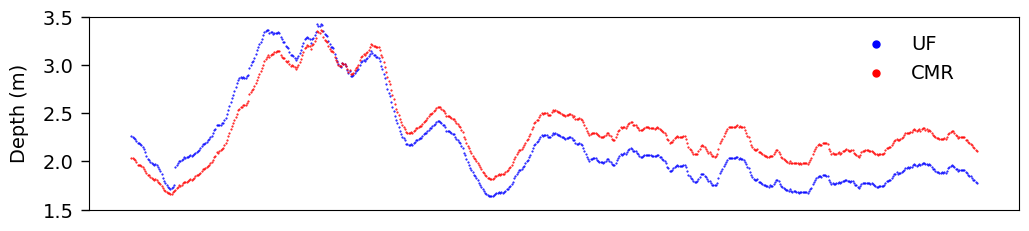

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))

fontsize = 14
labelpad = 10

ax.scatter(df[0:675].distance, river_bathymetry[0:675]['flood_depth_Neal_et_al'], color='blue', marker='.', label='UF', s=1)
ax.scatter(df[0:675].distance, river_bathymetry[0:675]['flood_depth_Rupp_and_Smart'], color='red', marker='.', label='CMR', s=1)
ax.set_ylabel('Depth (m)', fontsize=fontsize, labelpad=labelpad)
ax.legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(0.95, 1))

ax.set_xticks([])
ax.tick_params(bottom=False)

ax.set_ylim(ymin=1.5, ymax=3.5)
ax.locator_params(nbins=5, axis='y')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-8, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_depth_waikanae.jpg",
    bbox_inches='tight', dpi=600
)

### WAIKANAE PARAMETERS vs DEPTH

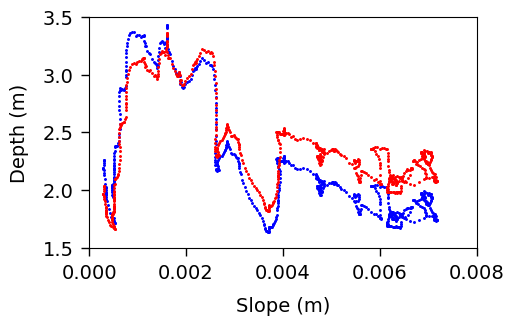

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.scatter(
    df[0:675]['slope'],
    river_bathymetry[0:675]['flood_depth_Neal_et_al'],
    color='blue',
    marker='.',
    s=5
)
ax.scatter(
    df[0:675]['slope'],
    river_bathymetry[0:675]['flood_depth_Rupp_and_Smart'],
    color='red',
    marker='.',
    s=5
)
ax.set_xlabel('Slope (m)', fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel('Depth (m)', fontsize=fontsize, labelpad=labelpad)


# ax.set_xticks([])
# ax.tick_params(bottom=False)

ax.set_ylim(ymin=1.5, ymax=3.5)
ax.set_xlim(xmin=0, xmax=0.008)
ax.locator_params(nbins=5, axis='y')
ax.locator_params(nbins=5, axis='x')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-8, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_slope_depth_waikanae.jpg",
    bbox_inches='tight', dpi=600
)

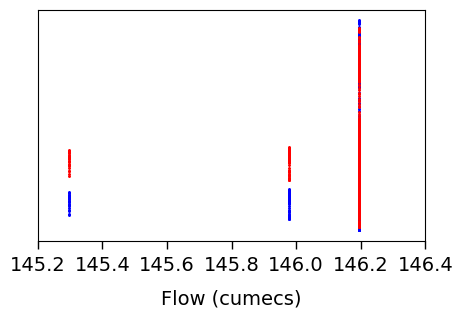

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.scatter(
    df[0:675]['flow'],
    river_bathymetry[0:675]['flood_depth_Neal_et_al'],
    color='blue',
    marker='.',
    s=5
)
ax.scatter(
    df[0:675]['flow'],
    river_bathymetry[0:675]['flood_depth_Rupp_and_Smart'],
    color='red',
    marker='.',
    s=5
)
ax.set_xlabel('Flow (cumecs)', fontsize=fontsize, labelpad=labelpad)

ax.set_yticks([])
ax.tick_params(left=False)

ax.set_xlim(xmin=145.2, xmax=146.4)
# ax.locator_params(nbins=5, axis='x')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-8, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_flow_depth_waikanae.jpg",
    bbox_inches='tight', dpi=600
)

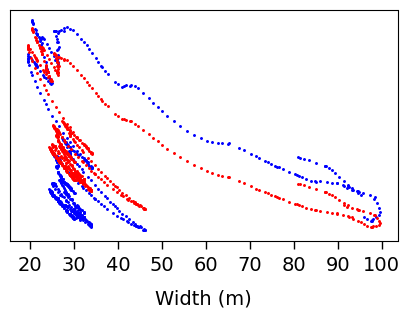

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.scatter(
    df[0:675]['width'],
    river_bathymetry[0:675]['flood_depth_Neal_et_al'],
    color='blue',
    marker='.',
    s=5
)
ax.scatter(
    df[0:675]['width'],
    river_bathymetry[0:675]['flood_depth_Rupp_and_Smart'],
    color='red',
    marker='.',
    s=5
)
ax.set_xlabel('Width (m)', fontsize=fontsize, labelpad=labelpad)

ax.set_yticks([])
ax.tick_params(left=False)

# ax.set_xlim(xmin=145.2, xmax=146.4)
# ax.locator_params(nbins=5, axis='x')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-8, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_width_depth_waikanae.jpg",
    bbox_inches='tight', dpi=600
)

### VARYING PARAMETERS

### 1. Varying SLOPE

In [15]:
# Calculate slope with means of w, q, and n
ws = river_characteristics[width_name][:675].mean()
print("mean width: ", ws)
qs = river_characteristics[flow_name][:675].mean()
print("mean flow: ", qs)
ns = river_characteristics[friction_name][:675].mean()
print("mean friction: ", ns)
ss = river_characteristics[slope_name][:675].mean()
print("mean slope: ", ss)

mean width:  35.62203456790123
mean flow:  146.14037800887303
mean friction:  0.04329407407407407
mean slope:  0.003966211541308261


In [16]:
# Calculate depth
neal_slope = calculate_neal_et_al(ws, ss, qs, ns)
rupp_slope = calculate_rupp_et_al(ws, ss, qs)

In [17]:
range_neal_slope = calculate_neal_et_al(ws, ss*np.arange(1.01, 2.01, 0.01), qs, ns)
range_rupp_slope = calculate_rupp_et_al(ws, ss*np.arange(1.01, 2.01, 0.01), qs)

Text(0.5, 1.0, 'Rupp')

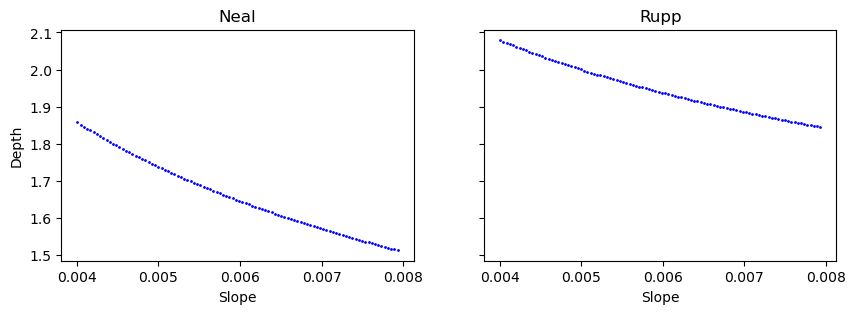

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Neal
ax[0].scatter(ss*np.arange(1.01, 2.01, 0.01), range_neal_slope, color='blue', s=1)
ax[0].set_xlabel('Slope')
ax[0].set_ylabel('Depth')
ax[0].set_title('Neal')

# Rupp
ax[1].scatter(ss*np.arange(1.01, 2.01, 0.01), range_rupp_slope, color='blue', s=1)
ax[1].set_xlabel('Slope')
ax[1].set_title('Rupp')

In [19]:
range_neal_slope.std() / range_neal_slope.mean() * 100

5.950410124785412

In [20]:
range_rupp_slope.std() / range_rupp_slope.mean() * 100

3.4573630109500515

### 2. Varying WIDTH

In [21]:
# Calculate slope with means of w, q, and n
sw = river_characteristics[slope_name][:675].mean()
print("mean slope: ", sw)
qw = river_characteristics[flow_name][:675].mean()
print("mean flow: ", qw)
nw = river_characteristics[friction_name][:675].mean()
print("mean friction: ", nw)
ww = river_characteristics[width_name][:675].mean()
print("mean width: ", ww)

mean slope:  0.003966211541308261
mean flow:  146.14037800887303
mean friction:  0.04329407407407407
mean width:  35.62203456790123


In [22]:
# Calculate depth
neal_width = calculate_neal_et_al(ww, sw, qw, nw)
rupp_width = calculate_rupp_et_al(ww, sw, qw)

In [23]:
# Calculate depth
range_neal_width = calculate_neal_et_al(ww*np.arange(1.01, 2.01, 0.01), sw, qw, nw)
range_rupp_width = calculate_rupp_et_al(ww*np.arange(1.01, 2.01, 0.01), sw, qw)

Text(0.5, 1.0, 'Rupp')

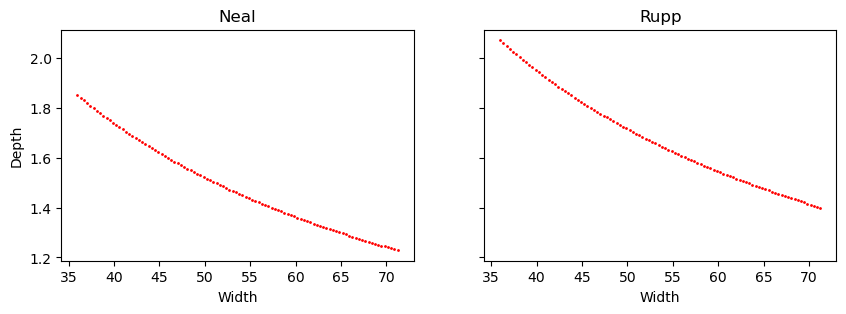

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Neal
ax[0].scatter(ww*np.arange(1.01, 2.01, 0.01), range_neal_width, color='red', s=1)
ax[0].set_xlabel('Width')
ax[0].set_ylabel('Depth')
ax[0].set_title('Neal')

# Rupp
ax[1].scatter(ww*np.arange(1.01, 2.01, 0.01), range_rupp_width, color='red', s=1)
ax[1].set_xlabel('Width')
ax[1].set_title('Rupp')

In [25]:
range_neal_width.std() / range_neal_width.mean() * 100

11.973155562241168

In [26]:
range_rupp_width.std() / range_rupp_width.mean() * 100

11.429779281428354

In [27]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharey=True)

# # Neal
# ax.scatter(ww, neal_width, color='blue', s=0.05)
# ax.scatter(ww, rupp_width, color='red', s=0.05)
# ax.set_xlabel('Width')
# ax.set_ylabel('Depth')

### 3. VARYING FLOW

In [28]:
# Calculate slope with means of w, q, and n
sq = river_characteristics[slope_name][:675].mean()
print("mean slope: ", sq)
wq = river_characteristics[width_name][:675].mean()
print("mean width: ", wq)
nq = river_characteristics[friction_name][:675].mean()
print("mean friction: ", nq)
qq = river_characteristics[flow_name][:675].mean()
print("mean flow: ", qw)

mean slope:  0.003966211541308261
mean width:  35.62203456790123
mean friction:  0.04329407407407407
mean flow:  146.14037800887303


In [204]:
np.unique(river_characteristics[flow_name][:675])

array([145.2962443 , 145.97780752, 146.19383417])

In [29]:
# Calculate depth
neal_flow = calculate_neal_et_al(wq, sq, qq, nq)
rupp_flow = calculate_rupp_et_al(wq, sq, qq)

In [30]:
# Calculate depth
range_neal_flow = calculate_neal_et_al(wq, sq, qq*np.arange(1.01, 2.01, 0.01), nq)
range_rupp_flow = calculate_rupp_et_al(wq, sq, qq*np.arange(1.01, 2.01, 0.01))

Text(0.5, 1.0, 'Rupp')

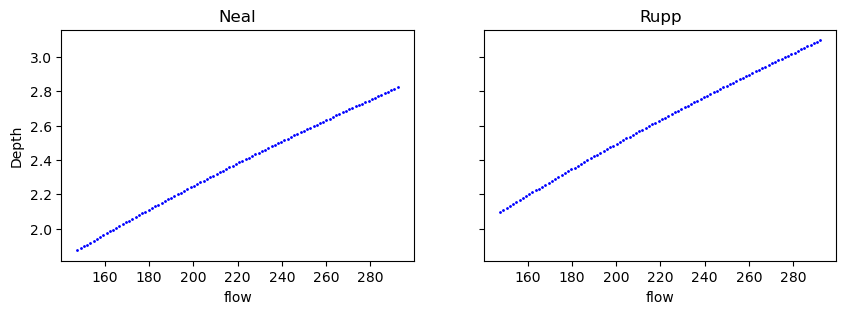

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Neal
ax[0].scatter(qq*np.arange(1.01, 2.01, 0.01), range_neal_flow, color='blue', s=1)
ax[0].set_xlabel('flow')
ax[0].set_ylabel('Depth')
ax[0].set_title('Neal')


# Rupp
ax[1].scatter(qq*np.arange(1.01, 2.01, 0.01), range_rupp_flow, color='blue', s=1)
ax[1].set_xlabel('flow')
ax[1].set_title('Rupp')

In [207]:
(qq*np.arange(1.01, 2.01, 0.01)).shape

(100,)

### 4. VARYING ALL

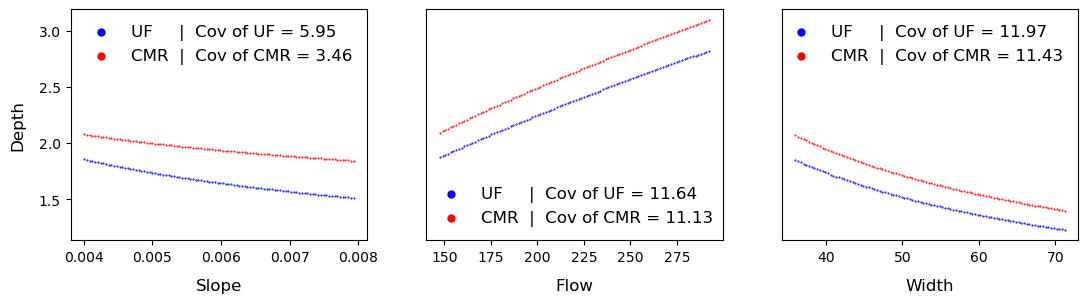

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3), sharey=True)

fontsize=12
labelpad=10

# Slope
ax[0].scatter(ss*np.arange(1.01, 2.01, 0.01), range_neal_slope, color='blue', s=1, marker='.', 
              label='UF     |  Cov of UF = {0:.2f}'.format(range_neal_slope.std() / range_neal_slope.mean() * 100))
ax[0].scatter(ss*np.arange(1.01, 2.01, 0.01), range_rupp_slope, color='red', s=1, marker='.', 
              label='CMR  |  Cov of CMR = {0:.2f}'.format(range_rupp_slope.std() / range_rupp_slope.mean() * 100))
ax[0].set_xlabel('Slope', fontsize=fontsize, labelpad=labelpad)
ax[0].set_ylabel('Depth', fontsize=fontsize, labelpad=labelpad)
ax[0].legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(1, 1))

# Flow
ax[1].scatter(qq*np.arange(1.01, 2.01, 0.01), range_neal_flow, color='blue', s=1, marker='.',
              label='UF     |  Cov of UF = {0:.2f}'.format(range_neal_flow.std() / range_neal_flow.mean() * 100))
ax[1].scatter(qq*np.arange(1.01, 2.01, 0.01), range_rupp_flow, color='red', s=1, marker='.',
              label='CMR  |  Cov of CMR = {0:.2f}'.format(range_rupp_flow.std() / range_rupp_flow.mean() * 100))
ax[1].set_xlabel('Flow', fontsize=fontsize, labelpad=labelpad)
ax[1].legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(1.02, 0.3))
ax[1].tick_params(left=False)


# Width
ax[2].scatter(ww*np.arange(1.01, 2.01, 0.01), range_neal_width, color='blue', s=1, marker='.',
              label='UF     |  Cov of UF = {0:.2f}'.format(range_neal_width.std() / range_neal_width.mean() * 100))
ax[2].scatter(ww*np.arange(1.01, 2.01, 0.01), range_rupp_width, color='red', s=1, marker='.',
              label='CMR  |  Cov of CMR = {0:.2f}'.format(range_rupp_width.std() / range_rupp_width.mean() * 100))
ax[2].set_xlabel('Width', fontsize=fontsize, labelpad=labelpad)
ax[2].legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
ax[2].tick_params(left=False)

# # Tick labels
# for axi in ax:
#     for item in (axi.get_xticklabels() + axi.get_yticklabels()):  # For x, y ticks' labels
#         item.set_fontsize(fontsize)
#     axi.tick_params(direction='out', length=fontsize-5, pad=fontsize-5, colors='white', width=3)
#     axi.locator_params(nbins=5, axis='y')

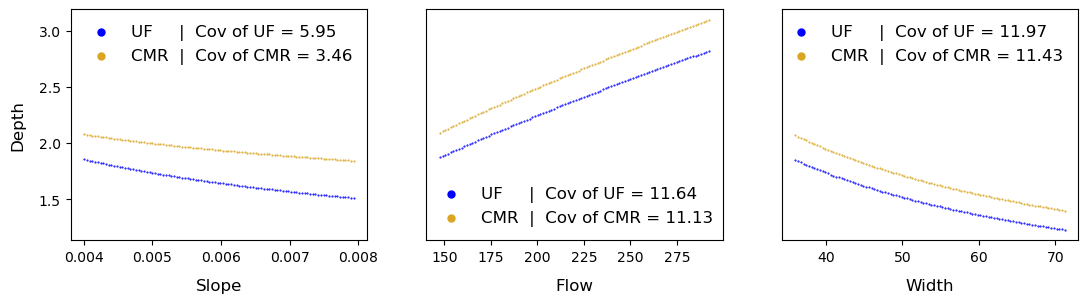

In [193]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3), sharey=True)

fontsize=12
labelpad=10

# Slope
ax[0].scatter(ss*np.arange(1.01, 2.01, 0.01), range_neal_slope, color='blue', s=1, marker='.', 
              label='UF     |  Cov of UF = {0:.2f}'.format(range_neal_slope.std() / range_neal_slope.mean() * 100))
ax[0].scatter(ss*np.arange(1.01, 2.01, 0.01), range_rupp_slope, color='goldenrod', s=1, marker='.', 
              label='CMR  |  Cov of CMR = {0:.2f}'.format(range_rupp_slope.std() / range_rupp_slope.mean() * 100))
ax[0].set_xlabel('Slope', fontsize=fontsize, labelpad=labelpad)
ax[0].set_ylabel('Depth', fontsize=fontsize, labelpad=labelpad)
ax[0].legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(1, 1))

# Flow
ax[1].scatter(qq*np.arange(1.01, 2.01, 0.01), range_neal_flow, color='blue', s=1, marker='.',
              label='UF     |  Cov of UF = {0:.2f}'.format(range_neal_flow.std() / range_neal_flow.mean() * 100))
ax[1].scatter(qq*np.arange(1.01, 2.01, 0.01), range_rupp_flow, color='goldenrod', s=1, marker='.',
              label='CMR  |  Cov of CMR = {0:.2f}'.format(range_rupp_flow.std() / range_rupp_flow.mean() * 100))
ax[1].set_xlabel('Flow', fontsize=fontsize, labelpad=labelpad)
ax[1].legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(1.02, 0.3))
ax[1].tick_params(left=False)


# Width
ax[2].scatter(ww*np.arange(1.01, 2.01, 0.01), range_neal_width, color='blue', s=1, marker='.',
              label='UF     |  Cov of UF = {0:.2f}'.format(range_neal_width.std() / range_neal_width.mean() * 100))
ax[2].scatter(ww*np.arange(1.01, 2.01, 0.01), range_rupp_width, color='goldenrod', s=1, marker='.',
              label='CMR  |  Cov of CMR = {0:.2f}'.format(range_rupp_width.std() / range_rupp_width.mean() * 100))
ax[2].set_xlabel('Width', fontsize=fontsize, labelpad=labelpad)
ax[2].legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
ax[2].tick_params(left=False)

# # Tick labels
# for axi in ax:
#     for item in (axi.get_xticklabels() + axi.get_yticklabels()):  # For x, y ticks' labels
#         item.set_fontsize(fontsize)
#     axi.tick_params(direction='out', length=fontsize-5, pad=fontsize-5, colors='white', width=3)
#     axi.locator_params(nbins=5, axis='y')

### Vary two parameters

In [246]:
# Calculate slope with means of w, q, and n
sq = river_characteristics[slope_name][:675].mean()
print("mean slope: ", sq)
wq = river_characteristics[width_name][:675].mean()
print("mean width: ", wq)
nq = river_characteristics[friction_name][:675].mean()
print("mean friction: ", nq)
qq = river_characteristics[flow_name][:675].mean()
print("mean flow: ", qw)

mean slope:  0.003966211541308261
mean width:  35.62203456790123
mean friction:  0.04329407407407407
mean flow:  146.14037800887303


In [247]:
# Calculate depth
neal_flow = calculate_neal_et_al(wq, sq, qq, nq)
rupp_flow = calculate_rupp_et_al(wq, sq, qq)

In [253]:
np.array(1-np.arange(.01, 1, 0.01))

array([0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78,
       0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67,
       0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56,
       0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47, 0.46, 0.45,
       0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35, 0.34,
       0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23,
       0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12,
       0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01])

In [255]:
# Calculate depth
range_neal_flow = calculate_neal_et_al(wq*np.array(1-np.arange(.01, 1, 0.01)), sq, qq, nq)
range_rupp_flow = calculate_rupp_et_al(wq*np.array(1-np.arange(.01, 1, 0.01)), sq, qq)

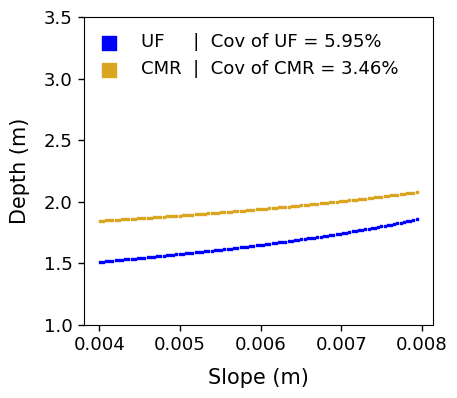

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), sharey=True)

fontsize=13
labelpad=10

# Slope
ax.scatter(sq*np.arange(1.01, 2.01, 0.01)[::-1], range_neal_slope, color='blue', s=1, marker='s', 
              label='UF     |  Cov of UF = {0:.2f}%'.format(range_neal_slope.std() / range_neal_slope.mean() * 100))
ax.scatter(sq*np.arange(1.01, 2.01, 0.01)[::-1], range_rupp_slope, color='goldenrod', s=1, marker='s', 
              label='CMR  |  Cov of CMR = {0:.2f}%'.format(range_rupp_slope.std() / range_rupp_slope.mean() * 100))
ax.set_xlabel('Slope (m)', fontsize=fontsize+2, labelpad=labelpad)
ax.set_ylabel('Depth (m)', fontsize=fontsize+2, labelpad=labelpad)
ax.legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(0.95, 1))

ax.set_ylim(ymin=1, ymax=3.5)
ax.locator_params(nbins=5, axis='y')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-9, pad=fontsize-9, colors='black', width=1)

# # Save fig
# fig.savefig(
#     "P:\Martin_publication\Bathymetry\All_results\S3_slope_formula.jpg",
#     bbox_inches='tight', dpi=600
# )

In [245]:
1 - np.arange(.01, 1.01, 0.01)

array([0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78,
       0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67,
       0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56,
       0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47, 0.46, 0.45,
       0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35, 0.34,
       0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23,
       0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12,
       0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01,
       0.  ])

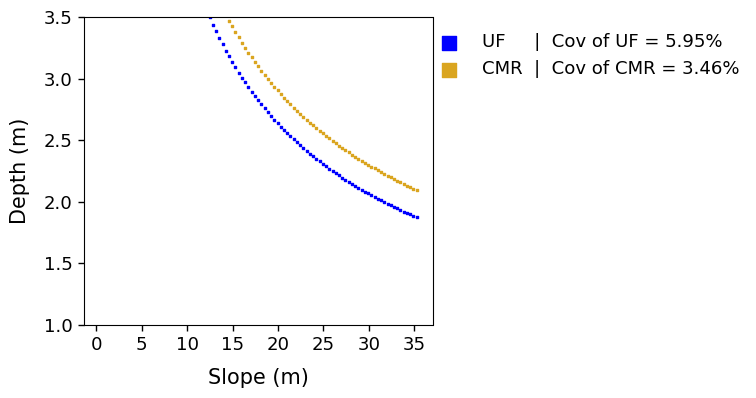

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), sharey=True)

fontsize=13
labelpad=10

# Slope
ax.scatter(wq*np.array(1-np.arange(.01, 1, 0.01)), range_neal_flow, color='blue', s=1, marker='s', 
              label='UF     |  Cov of UF = {0:.2f}%'.format(range_neal_slope.std() / range_neal_slope.mean() * 100))
ax.scatter(wq*np.array(1-np.arange(.01, 1, 0.01)), range_rupp_flow, color='goldenrod', s=1, marker='s', 
              label='CMR  |  Cov of CMR = {0:.2f}%'.format(range_rupp_slope.std() / range_rupp_slope.mean() * 100))
ax.set_xlabel('Slope (m)', fontsize=fontsize+2, labelpad=labelpad)
ax.set_ylabel('Depth (m)', fontsize=fontsize+2, labelpad=labelpad)
ax.legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(0.95, 1))

ax.set_ylim(ymin=1, ymax=3.5)
ax.locator_params(nbins=5, axis='y')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-9, pad=fontsize-9, colors='black', width=1)

# # Save fig
# fig.savefig(
#     "P:\Martin_publication\Bathymetry\All_results\S3_slope_formula.jpg",
#     bbox_inches='tight', dpi=600
# )

------------------------------------------------------

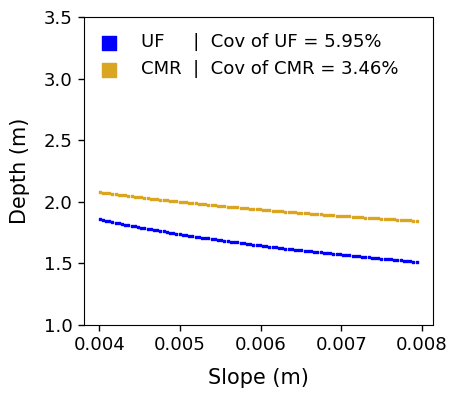

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), sharey=True)

fontsize=13
labelpad=10

# Slope
ax.scatter(ss*np.arange(1.01, 2.01, 0.01), range_neal_slope, color='blue', s=1, marker='s', 
              label='UF     |  Cov of UF = {0:.2f}%'.format(range_neal_slope.std() / range_neal_slope.mean() * 100))
ax.scatter(ss*np.arange(1.01, 2.01, 0.01), range_rupp_slope, color='goldenrod', s=1, marker='s', 
              label='CMR  |  Cov of CMR = {0:.2f}%'.format(range_rupp_slope.std() / range_rupp_slope.mean() * 100))
ax.set_xlabel('Slope (m)', fontsize=fontsize+2, labelpad=labelpad)
ax.set_ylabel('Depth (m)', fontsize=fontsize+2, labelpad=labelpad)
ax.legend(prop={"size":fontsize}, markerscale=10, frameon=False, bbox_to_anchor=(0.95, 1))

ax.set_ylim(ymin=1, ymax=3.5)
ax.locator_params(nbins=5, axis='y')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-9, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_slope_formula.jpg",
    bbox_inches='tight', dpi=600
)

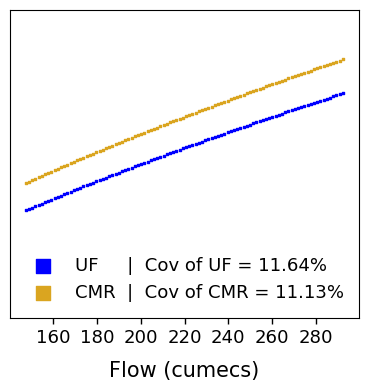

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), sharey=True)

fontsize=13
labelpad=10

# flow
ax.scatter(qq*np.arange(1.01, 2.01, 0.01), range_neal_flow, color='blue', s=1, marker='s', 
              label='UF     |  Cov of UF = {0:.2f}%'.format(range_neal_flow.std() / range_neal_flow.mean() * 100))
ax.scatter(qq*np.arange(1.01, 2.01, 0.01), range_rupp_flow, color='goldenrod', s=1, marker='s', 
              label='CMR  |  Cov of CMR = {0:.2f}%'.format(range_rupp_flow.std() / range_rupp_flow.mean() * 100))
ax.set_xlabel('Flow (cumecs)', fontsize=fontsize+2, labelpad=labelpad)
ax.legend(prop={"size":fontsize}, markerscale=10, frameon=False, loc='lower center')

ax.set_yticklabels([])
ax.tick_params(left=False)

ax.set_ylim(ymin=1, ymax=3.5)
ax.locator_params(nbins=5, axis='y')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-9, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_flow_formula.jpg",
    bbox_inches='tight', dpi=600
)

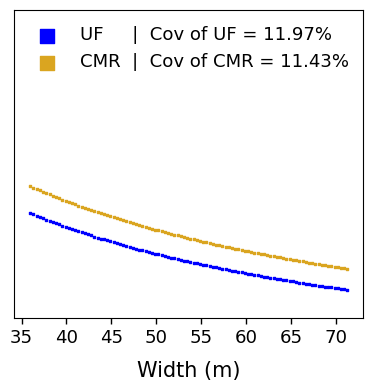

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), sharey=True)

fontsize=13
labelpad=10

# width
ax.scatter(ww*np.arange(1.01, 2.01, 0.01), range_neal_width, color='blue', s=1, marker='s', 
              label='UF     |  Cov of UF = {0:.2f}%'.format(range_neal_width.std() / range_neal_width.mean() * 100))
ax.scatter(ww*np.arange(1.01, 2.01, 0.01), range_rupp_width, color='goldenrod', s=1, marker='s', 
              label='CMR  |  Cov of CMR = {0:.2f}%'.format(range_rupp_width.std() / range_rupp_width.mean() * 100))
ax.set_xlabel('Width (m)', fontsize=fontsize+2, labelpad=labelpad)
ax.legend(prop={"size":fontsize}, markerscale=10, frameon=False, loc='upper center')

ax.set_yticklabels([])
ax.tick_params(left=False)

ax.set_ylim(ymin=1, ymax=3.5)
ax.locator_params(nbins=5, axis='y')

for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize)
ax.tick_params(direction='out', length=fontsize-9, pad=fontsize-9, colors='black', width=1)

# Save fig
fig.savefig(
    "P:\Martin_publication\Bathymetry\All_results\S3_width_formula.jpg",
    bbox_inches='tight', dpi=600
)

### VARY ALL AT THE SAME TIME

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

# Neal
ax.scatter(neal_v[100:590], df['width'][100:590], c=df['slope'][100:590], cmap='viridis', s=5)
ax.set_xlabel('width')
ax.set_ylabel('Depth')
ax.set_title('Neal')

In [ ]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.4, hspace=hspace)


# Width
cb0 = ax[0].scatter(df['width'][100:590], neal_v[100:590], c=df['slope'][100:590], cmap='rainbow', s=5)
ax[0].set_xlabel('width')
ax[0].set_ylabel('Depth')
ax[0].set_title('Neal')

divider_000 = make_axes_locatable(ax[0])
cax = divider_000.append_axes('right', size='2%', pad=0.05)
fig.colorbar(cb0, cax=cax, orientation='vertical')

# Slope
cb1 = ax[1].scatter(df['slope'][100:590], neal_v[100:590], c=df['width'][100:590], cmap='rainbow', s=5)
ax[1].set_xlabel('slope')
ax[1].set_title('Neal')

divider_001 = make_axes_locatable(ax[1])
cax = divider_001.append_axes('right', size='2%', pad=0.05)
fig.colorbar(cb1, cax=cax, orientation='vertical')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.4, hspace=hspace)


# Slope - Neal
cb1 = ax[0].scatter(df['slope'][100:590], neal_v[100:590], c=df['width'][100:590], cmap='rainbow', s=20)
ax[0].set_xlabel('slope')

divider_001 = make_axes_locatable(ax[0])
cax = divider_001.append_axes('right', size='5%', pad=0.2)
fig.colorbar(cb1, cax=cax, orientation='vertical')

# Slope - Rupp
cb2 = ax[1].scatter(df['slope'][100:590], rupp_v[100:590], c=df['width'][100:590], cmap='rainbow', s=20)
ax[1].set_xlabel('slope')

divider_002 = make_axes_locatable(ax[1])
cax = divider_002.append_axes('right', size='5%', pad=0.2)
fig.colorbar(cb2, cax=cax, orientation='vertical')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.4, hspace=hspace)


# Slope - Neal
cb1 = ax[0].scatter(df['slope'][40:100], neal_v[40:100], c=df['width'][40:100], cmap='rainbow', s=5)
ax[0].set_xlabel('slope')

divider_001 = make_axes_locatable(ax[0])
cax = divider_001.append_axes('right', size='2%', pad=0.05)
fig.colorbar(cb1, cax=cax, orientation='vertical')

# Slope - Rupp
cb2 = ax[1].scatter(df['slope'][40:100], rupp_v[40:100], c=df['width'][40:100], cmap='rainbow', s=5)
ax[1].set_xlabel('slope')

divider_002 = make_axes_locatable(ax[1])
cax = divider_002.append_axes('right', size='2%', pad=0.05)
fig.colorbar(cb2, cax=cax, orientation='vertical')